# PRISM studies

**_must run with dfs created with the full selection_**

In [30]:
%load_ext autoreload
%autoreload 2

#print all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
from os import path
import sys
import uproot
from tqdm import tqdm
import pickle

# local imports
from variable_configs import *

sys.path.append('../../')
from analysis_village.unfolding.wienersvd import *
from analysis_village.unfolding.unfolding_inputs import *
from analysis_village.numucc1p0pi.selection_definitions import *
from pyanalib.split_df_helpers import *
from makedf.geniesyst import regen_systematics_sbnd_multisigma, regen_systematics_sbnd_morph
from makedf.constants import *

plt.style.use("presentation.mplstyle")

# filter Performance warning
import warnings
from pandas.errors import PerformanceWarning
warnings.filterwarnings("ignore", category=PerformanceWarning)

In [32]:
save_fig = False
save_fig_dir = "/exp/sbnd/data/users/munjung/plots/numucc1p0pi/prism"

# load dataframes

In [33]:
file_dir = "/exp/sbnd/data/users/munjung/xsec/NuINT2025"

## -- MC 
# selected
mc_file = path.join(file_dir, "MC_bnb_cosmics_finalsel.df")
mc_split_df = pd.read_hdf(mc_file, key="split")
mc_n_split = get_n_split(mc_file)
print("mc_n_split: %d" %(mc_n_split))
print_keys(mc_file)

mc_n_split: 5
Keys: ['/evt_0', '/evt_1', '/evt_2', '/evt_3', '/evt_4', '/hdr_0', '/hdr_1', '/hdr_2', '/hdr_3', '/hdr_4', '/mcnu_0', '/mcnu_1', '/mcnu_2', '/mcnu_3', '/mcnu_4', '/split']


In [34]:
# concat dfs 
n_max_concat = 20

mc_keys2load = ['hdr', 'evt', 'mcnu']
mc_dfs = load_dfs(mc_file, mc_keys2load, n_max_concat=n_max_concat)
mc_hdr_df = mc_dfs['hdr']
mc_evt_df = mc_dfs['evt']
mc_nu_df = mc_dfs['mcnu']

In [35]:
data_file = path.join(file_dir, "Data_dev_fullsel.df")
data_split_df = pd.read_hdf(data_file, key="split")
data_n_split = get_n_split(data_file)
print("data_n_split: %d" %(data_n_split))
print_keys(data_file)

data_keys2load = ['evt', 'hdr']
data_dfs = load_dfs(data_file, data_keys2load, n_max_concat=n_max_concat)
data_evt_df = data_dfs['evt']
data_hdr_df = data_dfs['hdr']

data_n_split: 2
Keys: ['/bnbpot_0', '/bnbpot_1', '/evt_0', '/evt_1', '/hdr_0', '/hdr_1', '/split', '/trk_0', '/trk_1']


In [36]:
from pyanalib.variable_calculator import get_cc1p0pi_tki
from pyanalib.pandas_helpers import pad_column_name
P_mu_col = pad_column_name(("totp",), mc_nu_df.mu)
P_p_col = pad_column_name(("totp",), mc_nu_df.p)
ret_tki = get_cc1p0pi_tki(mc_nu_df.mu, mc_nu_df.p, P_mu_col, P_p_col)
mc_nu_df["del_Tp"] = ret_tki["del_Tp"]
mc_nu_df["del_Tp_x"] = ret_tki["del_Tp_x"]
mc_nu_df["del_Tp_y"] = ret_tki["del_Tp_y"]
mc_nu_df["del_p"] = ret_tki["del_p"]
mc_nu_df["del_alpha"] = ret_tki["del_alpha"]
mc_nu_df["del_phi"] = ret_tki["del_phi"]

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [37]:
data_tot_pot = data_hdr_df['pot'].sum()
print("data_tot_pot: %.3e" %(data_tot_pot))

mc_tot_pot = mc_hdr_df['pot'].sum()
print("mc_tot_pot: %.10e" %(mc_tot_pot))

mc_pot_scale = data_tot_pot / mc_tot_pot
print("mc_pot_scale: %.3e" %(mc_pot_scale))
mc_evt_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_evt_df))

# mc_tot_pot = mc_hdr_df['pot'].sum()
# print("mc_tot_pot: %.10e" %(mc_tot_pot))

# mc_pot_scale = data_tot_pot / mc_tot_pot
# mc_pot_scale = 1.0
# print("mc_pot_scale: %.3e" %(mc_pot_scale))
# mc_evt_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_evt_df))

data_tot_pot: 7.370e+18
mc_tot_pot: 5.8562716084e+20
mc_pot_scale: 1.259e-02


In [38]:
mc_evt_df.loc[:,'nuint_categ'] = get_int_category(mc_evt_df)
mc_evt_df.loc[:,'genie_categ'] = get_genie_category(mc_evt_df)
print(mc_evt_df.nuint_categ.value_counts())
print(mc_evt_df.genie_categ.value_counts())

mc_nu_df.loc[:,'nuint_categ'] = get_int_category(mc_nu_df)
mc_nu_df.loc[:,'genie_categ'] = get_genie_category(mc_nu_df)
print(mc_nu_df.nuint_categ.value_counts())
print(mc_nu_df.genie_categ.value_counts())

nuint_categ
 1    73575
 2     2279
 3     2238
 4     1176
-1      393
 5       98
 0       82
Name: count, dtype: int64
genie_categ
 1    65266
 2     9586
 3     3130
 6     1176
-1      393
 4      101
 7       98
 0       82
 5        9
Name: count, dtype: int64
nuint_categ
0    8678581
3    1296685
4     941525
1     744745
2     328118
5      55677
Name: count, dtype: int64
genie_categ
0    8678581
1    1253365
6     941525
3     668227
2     317791
4     125984
7      55677
5       4181
Name: count, dtype: int64


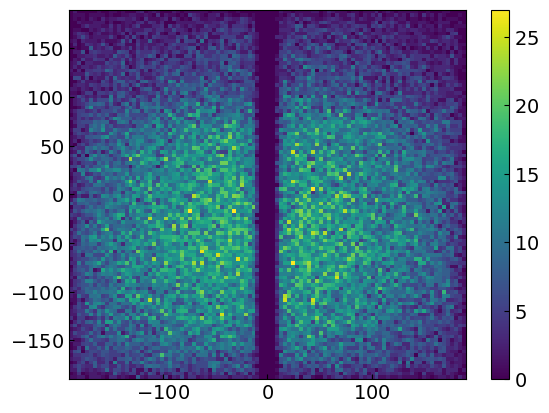

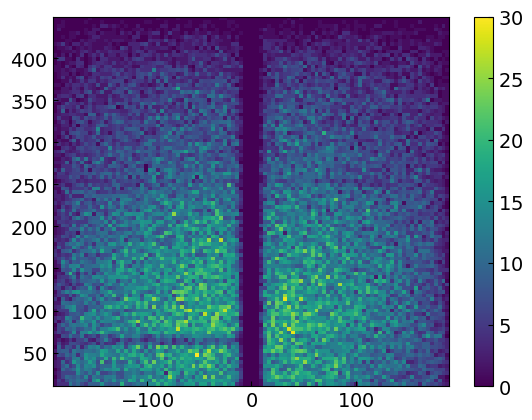

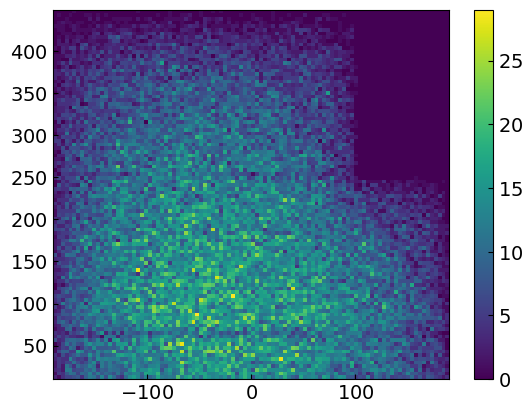

In [39]:
plt.hist2d(mc_evt_df.slc.vertex.x, mc_evt_df.slc.vertex.y, bins=100, cmap="viridis")
plt.colorbar()
plt.show();

plt.hist2d(mc_evt_df.slc.vertex.x, mc_evt_df.slc.vertex.z, bins=100, cmap="viridis")
plt.colorbar()
plt.show();

plt.hist2d(mc_evt_df.slc.vertex.y, mc_evt_df.slc.vertex.z, bins=100, cmap="viridis")
plt.colorbar()
plt.show();

In [49]:
mc_nu_df.genie_mode

__ntuple  entry  rec.mc.nu..index
0         0      0                    1
          1      0                    0
                 1                   10
                 2                    0
                 3                    1
                                     ..
389       16853  1                    0
                 2                    1
          16854  0                    0
                 1                    0
          16855  0                    0
Name: genie_mode, Length: 12045331, dtype: int16

0.5153986219822485 0.5386980614088576


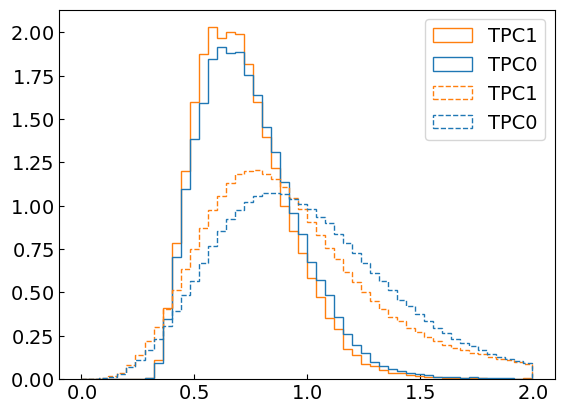

In [54]:
mc_tpc0_df = mc_evt_df[mc_evt_df.position.x < -20]
mc_tpc1_df = mc_evt_df[mc_evt_df.position.x > 20]
mcnu_tpc0_df = mc_nu_df[(InFV(mc_nu_df.position) & (mc_nu_df.position.x < -20))]
mcnu_tpc1_df = mc_nu_df[(InFV(mc_nu_df.position) & (mc_nu_df.position.x > 20))]

bins = np.linspace(0, 2, 51)
colors = ["C0", "C1"]
var = [mc_tpc0_df.E, mc_tpc1_df.E]
plt.hist(var, bins=bins, histtype="step", label=["TPC0", "TPC1"], density=True, color=colors)
var = [mcnu_tpc0_df.E, mcnu_tpc1_df.E]
print(len(mcnu_tpc0_df[mcnu_tpc0_df.genie_mode == 0])/ len(mcnu_tpc0_df), len(mcnu_tpc1_df[mcnu_tpc1_df.genie_mode == 0])/ len(mcnu_tpc1_df))
plt.hist(var, bins=bins, histtype="step", label=["TPC0", "TPC1"], linestyle="--", density=True, color=colors)
plt.legend()
plt.show();


In [ ]:
var = [mc_tpc0_df.mc_del_Tp, mc_tpc1_df.mc_del_Tp]
bins = np.linspace(0, 1, 51)
plt.hist(var, bins=bins, histtype="step", label=["TPC0", "TPC1"])
plt.legend()
plt.show();

var = [mc_tpc0_df.del_Tp, mc_tpc1_df.del_Tp]
bins = np.linspace(0, 1, 51)
plt.hist(var, bins=bins, histtype="step", label=["TPC0", "TPC1"])
plt.legend()
plt.show();